# Batch Processing Error Detection

Original data from:

https://kuleuven.app.box.com/v/batchbenchmark/4/3864480711

Data downloaded from:
https://kuleuven.app.box.com/v/batchbenchmark/4/3864480711

Data explanation in:
simulated_data_paper.pdf

An extensive reference dataset for fault detection and identification in batch processes

Chemometrics and Intelligent Laboratory Systems
Volume 148, 15 November 2015, Pages 20–31

Jan Van Impe, Geert Gins (2015), An Extensive Reference Data Set for Fault Detection and Isolation in Batch Processes. (accepted for publication in Chemometrics & Intelligent Laboratory Systems).


## Import and explore file structure

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import shift
%matplotlib inline


Looking first at the measurement data.

The measurements available are:

![data](offline_data.png)

with online data:

![data](online_data.png)

In [2]:
filepath = 'Aligned_set_1_BASE_NOC/Aligned_set_1_BASE_NOC.mat'
f=h5py.File(filepath, 'r')
for k in range(24):
    st=f["/MeasurementsTags"][0][k]
    obj = f[st]
    str1 = ''.join(chr(i) for i in obj[:])
    print('Var', k, ':', str1 )

Var 0 : Time
Var 1 : Fermentation volume
Var 2 : Biomass concentration
Var 3 : Substrate concentration
Var 4 : Penicillin concentration
Var 5 : Dissolved oxygen concentration
Var 6 : Dissolved CO2 concentration
Var 7 : Reactor temperature
Var 8 : pH
Var 9 : Reaction heat
Var 10 : Feed rate
Var 11 : Feed substrate concentration
Var 12 : Feed temperature
Var 13 : Aeration rate
Var 14 : Agitator power
Var 15 : Cooling/heating medium flow rate
Var 16 : Cooling medium temperature
Var 17 : Heating medium temperature
Var 18 : Hot/cold switch
Var 19 : Base flow
Var 20 : Acid flow
Var 21 : Cumulative base flow
Var 22 : Cumulative acid flow
Var 23 : True penicillin concentration


# Data With Faults
The faults look like this:

![fault](faults.png)

In [3]:
# First get golden data
filepath = 'Aligned_set_1_BASE_NOC/Aligned_set_1_BASE_NOC.mat'
g=h5py.File(filepath, 'r')
onlinevars = [ 1, 5, 6, 7, 8, 10, 12, 14, 15, 19, 20]
nofaultmat = g["/Measurements"][:,onlinevars,:]
nofaultmat.shape

(1201, 11, 400)

New approach: set up a new set of features that include the past N data points:

(N=3):
x03 x13 x23 x33 x02 x12 x22 x32 x01 x11 x21 x31 x00 x10 x20 x30

to get there: first create the new columns from prior data, create a column for the label, then flatten everything.




Variables to use (online monitoring):
0, 1, 5, 6, 7, 8, 10, 12, 14, 15, 19, 20

Subsetting, normalizing, and image-generation

In [11]:
def enrichMat(m1,label):
    m1shift1=shift(m1, [1,0,0], cval=0)
    m1shift2=shift(m1, [2,0,0], cval=0)
    #m1shift3=shift(m1, [3,0,0], cval=0)

    m1class = np.ones((m1.shape[0],1,m1.shape[2]))*label

    m1new=np.concatenate((m1class,m1,m1shift1,m1shift2),axis=1)
                         #,m1shift3)


    #print(m1new.shape)
    m1new=np.swapaxes(m1new,1,2)
    m1reshape = m1new.reshape((-1,m1new.shape[2]))
    return m1reshape

def getData(faultNums,
            onlinevars):

    
    # First get golden data
    filepath = 'Aligned_set_1_BASE_NOC/Aligned_set_1_BASE_NOC.mat'
    g=h5py.File(filepath, 'r')
    nofaultmat = g["/Measurements"][:,onlinevars,:]
    outputMat = enrichMat(nofaultmat,0)
    
    ifault=1
    for faultNum in faultNums:
        filepath = 'Aligned_set_1_BASE_fault_{0}/Aligned_set_1_BASE_fault_{0}.mat'.format(faultNum)
        f = h5py.File(filepath, 'r')
        # Get all of the fault data
        fmat = f["/Measurements"][:,onlinevars,:]
        
        #randomize it so we don't get all of one fault
        shuffle = np.random.rand(fmat.shape[0]).argsort()
        datarand = np.take(fmat,shuffle,axis=0)
        
        # use only the same amount of data as our nofaultmat
        newMat = enrichMat(datarand[:,:,:nofaultmat.shape[2]],ifault)
        outputMat=np.append(outputMat,newMat,axis=0)
        ifault += 1
        
        
    return outputMat
allmat = getData([1,9,11],onlinevars = [ 1, 5, 6, 7, 8, 10, 12, 14, 15, 21, 22])   



allmat.shape

(1921600, 34)

Ok, some metrics: not using any of the mshift points, I got about 70% accuracy in around 80 rounds using XGBoost. I'm now trying to add a single prior point to see if it helps training.

Adding in the first shift significantly improves the model! I've got 89% accuracy after 100 rounds (saved in 0001.model)

Trying the second shift, too.



In [12]:
# First, shuffle the data
shuffle = np.random.rand(allmat.shape[0]).argsort()
datarand = np.take(allmat,shuffle,axis=0)

# take a smaller subset to work with

#datarand = datarand[:100000,:]

ntrain = int(datarand.shape[0]*0.8)
train_features = datarand[:ntrain, 1:]
train_labels = datarand[:ntrain,0]
test_features = datarand[ntrain:, 1:]
test_labels = datarand[ntrain:,0]

In [13]:
import xgboost as xgb

dtrain = xgb.DMatrix(train_features, label=train_labels)
dtest= xgb.DMatrix(test_features,label=test_labels)

watchlist  = [(dtest,'eval'), (dtrain,'train')]
param = {'max_depth':10, 'eta':0.3, 'silent':0, 'gamma':5,'objective':'multi:softprob','num_class':len(np.unique(datarand[:,0])) }
num_round = 100
bst = xgb.train(param, dtrain, num_round,watchlist)



[0]	eval-merror:0.262726	train-merror:0.260177
[1]	eval-merror:0.249068	train-merror:0.246674
[2]	eval-merror:0.243672	train-merror:0.240958
[3]	eval-merror:0.237555	train-merror:0.233955
[4]	eval-merror:0.229179	train-merror:0.225764
[5]	eval-merror:0.217269	train-merror:0.2131
[6]	eval-merror:0.202324	train-merror:0.197991
[7]	eval-merror:0.192327	train-merror:0.187939
[8]	eval-merror:0.189189	train-merror:0.184536
[9]	eval-merror:0.180165	train-merror:0.174977
[10]	eval-merror:0.175016	train-merror:0.169342
[11]	eval-merror:0.16691	train-merror:0.161116
[12]	eval-merror:0.163257	train-merror:0.157084
[13]	eval-merror:0.158711	train-merror:0.152422
[14]	eval-merror:0.153596	train-merror:0.147172
[15]	eval-merror:0.150557	train-merror:0.143857
[16]	eval-merror:0.147247	train-merror:0.140302
[17]	eval-merror:0.143846	train-merror:0.13675
[18]	eval-merror:0.1398	train-merror:0.132541
[19]	eval-merror:0.136131	train-merror:0.128875
[20]	eval-merror:0.131986	train-merror:0.124778
[21]	eva

The model with a single set of prior readings is pretty good. I'm saving it just in case the other models don't do any better.

In [14]:
bst.save_model('0002.model')

Accuracy Score: 0.9534944837635304


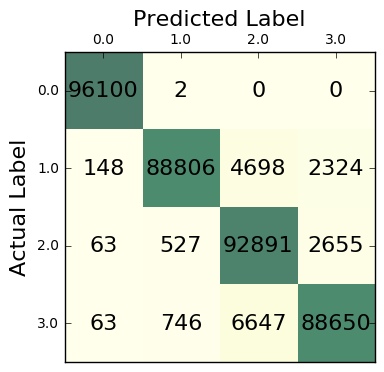

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# make prediction
preds = bst.predict(dtest)

y_pred = np.argmax(preds,axis=1)

def show_confusion_matrix(cnf_matrix, class_labels):
    plt.matshow(cnf_matrix,cmap=plt.cm.YlGn,alpha=0.7)
    ax = plt.gca()
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks(range(0,len(class_labels)))
    ax.set_xticklabels(class_labels)
    ax.set_ylabel('Actual Label', fontsize=16, rotation=90)
    ax.set_yticks(range(0,len(class_labels)))
    ax.set_yticklabels(class_labels)
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()

    for row in range(len(cnf_matrix)):
        for col in range(len(cnf_matrix[row])):
            ax.text(col, row, cnf_matrix[row][col], va='center', ha='center', fontsize=16)


cnf_matrix = confusion_matrix(test_labels, y_pred)
show_confusion_matrix(cnf_matrix,np.unique(datarand[:,0]))
acc_score = accuracy_score(test_labels, y_pred)

print("Accuracy Score: {}".format(acc_score))

So this is doing a reasonable job, which is good!

Trying all the faults (on a faster machine).
